In [1]:
import warnings
warnings.simplefilter('ignore')

import string
import json
import itertools
import YelpCleanData as cd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.util import ngrams

In [2]:
user_business_df = cd.load_data('data/rating_history.csv')
cat_split_city = user_business_df['categories'].apply(lambda x: list(set(list(map(str.strip, x.split(','))))) if x is not None else 'None')
user_business_df['categories'] = cat_split_city
cat_merged = set(itertools.chain(*list(cat_split_city.values)))

In [3]:
business = cd.open_json('data/business.json')
df_business = pd.json_normalize(business)

In [4]:
cat_split_entire = df_business['categories'].apply(lambda x: list(set(list(map(str.strip, x.split(','))))) if x is not None else 'None')
df_business['categories'] = cat_split_entire

In [5]:
model = cd.build_word2vec(cat_split_entire, window=20, sg=0, negative=20, alpha=0.03, min_alpha=0.001, epochs=20)

In [6]:
# Mapping StockCode with similarity scores with respect to categories existing in the prediction set
category = 'Brazilian'
similar_df = cd.get_similar_cat_df(model, category)
similar_df = similar_df[similar_df['Category'].isin(cat_merged)].reset_index(drop=True)
similar_df.head()

,Category,Similarity
0,Brazilian,1.000000
1,Argentine,0.662890
2,Peruvian,0.532551
3,Basque,0.531147
4,Spanish,0.501794


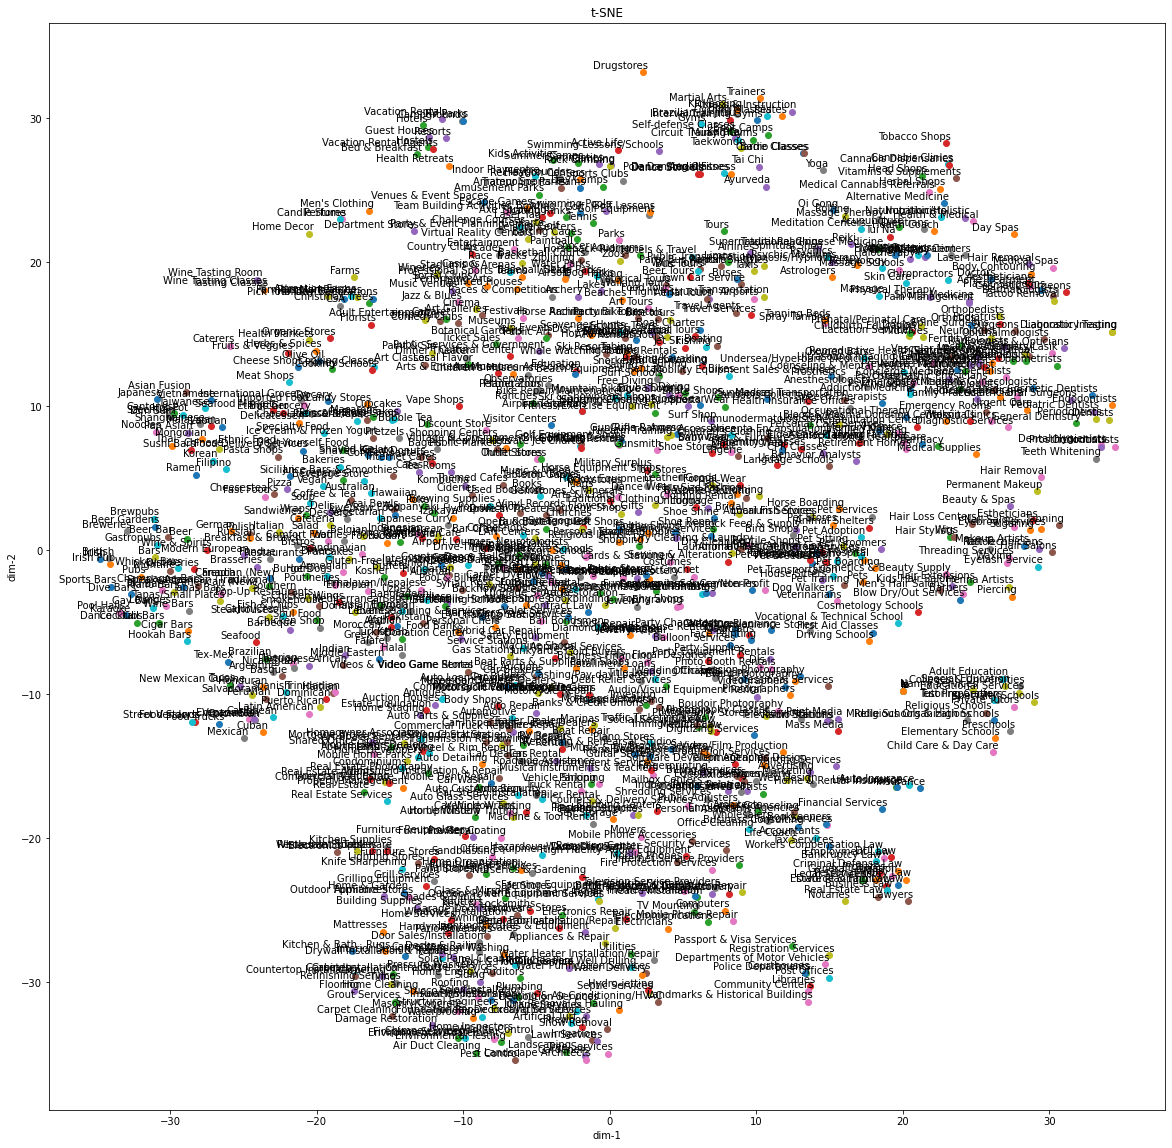

In [7]:
# TSNE for Visualization
embeddings, cat_label = cd.get_tsne_embedding(model, 40, 2, 10000)
cd.tsne_plot(embeddings, cat_label)

In [8]:
b_id = 'QdN72BWoyFypdGJhhI5r7g'
b_info = cd.get_business_info_from_id(b_id)
cd.print_business_info(b_info)

Business Name: Bar One
Business Address: 767 S 9th St, Philadelphia, PA, 19147
Average Stars: 4.0
Business Categories: Cocktail Bars, Bars, Italian, Nightlife, Restaurants


In [9]:
refer_reviews_df = cd.get_refer_table(b_id, isHighRatings=True).reset_index(drop=True)

In [10]:
b_cat = user_business_df[user_business_df['business_id'] == b_id]['categories'].iloc[0][0]
similar_cat = cd.get_n_similar_cat(model, b_cat, cat_merged, 5)

In [11]:
ref_df = cd.get_potential_reviewers_history_from_today(user_business_df, refer_reviews_df, similar_cat, 5, isHigh=True)
nlp_df = cd.get_most_recent_reviews(ref_df)
text_series = cd.text_cleaning(nlp_df['text'], n_gram=2)

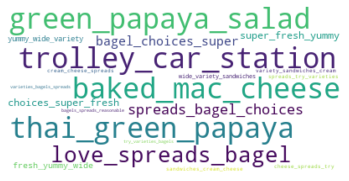

In [70]:
cd.draw_word_cloud(text_series, max_word=20)

Business Name: Bar One
Business Address: 767 S 9th St, Philadelphia, PA, 19147
Average Stars: 4.0
Business Categories: Cocktail Bars, Bars, Italian, Nightlife, Restaurants


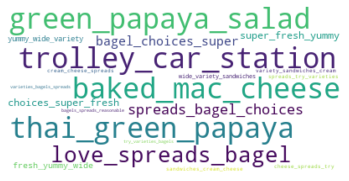

In [25]:
if __name__ == "__main__":
    b_id = 'QdN72BWoyFypdGJhhI5r7g'
    b_info = cd.get_business_info_from_id(b_id)
    if b_info is None:
        print('No such Business ID')
#         return
    cd.print_business_info(b_info)
    
    refer_reviews_df = cd.get_refer_table(b_id, isHighRatings=True).reset_index(drop=True)
    
    b_cat = user_business_df[user_business_df['business_id'] == b_id]['categories'].iloc[0][0]
    similar_cat = cd.get_n_similar_cat(model, b_cat, cat_merged, n=5)
    
    ref_df = cd.get_potential_reviewers_history_from_today(user_business_df, refer_reviews_df, similar_cat, year_diff=5, isHigh=True)
    nlp_df = cd.get_most_recent_reviews(ref_df)
    text_series = cd.text_cleaning(nlp_df['text'], n_gram=3)
    
    cd.draw_word_cloud(text_series, max_word=20)

Business Name: Bar One
Business Address: 767 S 9th St, Philadelphia, PA, 19147
Average Stars: 4.0
Business Categories: Cocktail Bars, Bars, Italian, Nightlife, Restaurants


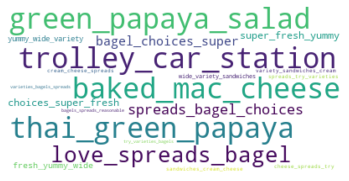

In [43]:
if __name__ == "__main__":
    b_id = 'QdN72BWoyFypdGJhhI5r7g'
    b_info = cd.get_business_info_from_id(b_id)
    if b_info is None:
        print('No such Business ID')
#         return
    cd.print_business_info(b_info)
    
    refer_reviews_df = cd.get_refer_table(b_id, isHighRatings=True).reset_index(drop=True)
    
    b_cat = user_business_df[user_business_df['business_id'] == b_id]['categories'].iloc[0][0]
    similar_cat = cd.get_n_similar_cat(model, b_cat, cat_merged, n=5)
    
    ref_df = cd.get_potential_reviewers_history_from_today(user_business_df, refer_reviews_df, similar_cat, year_diff=5, isHigh=True)
    nlp_df = cd.get_most_recent_reviews(ref_df)
    text_series = cd.text_cleaning(nlp_df['text'], n_gram=3)
    
#     cd.draw_word_cloud(text_series, max_word=20)
    wordcloud = WordCloud(max_words=20, background_color="white", random_state=1).generate(text_series.str.cat(sep=' '))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('test.jpg')
    plt.show()    

In [62]:
sim_dict = dict()
for elem in cat_merged:
    if elem in model.wv.key_to_index:
        sim_array = np.array(model.wv.similar_by_vector(elem, topn=len(model.wv.key_to_index)))
        sim_cat = np.array(list(map(lambda x:x[0], sim_array)))
        sim_array2 = sim_array[np.isin(sim_cat, np.array(list(cat_merged)))]
        sim_dict[elem] = sim_array2

In [52]:
with open('sim.pkl', 'wb') as p:
    pickle.dump(sim_dict, p)